# Part B

The goal of this part is to predict the player position based on the attributes given in FIFA 19 dataset.

In [1]:
!pip install prettytable

You should consider upgrading via the 'c:\users\legion 5 ecin\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [205]:
# Importing the necessary libraries

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")

In [3]:
large = 22; med = 16; small = 10
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'axes.linewidth': 2,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)

In [4]:
# Loading the data
df = pd.read_csv('./data/players_19.csv')

# Let have a quick look at the data
df.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,33,1985-02-05,187,83,Portugal,Juventus,...,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
1,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,31,1987-06-24,170,72,Argentina,FC Barcelona,...,63+2,61+2,61+2,61+2,63+2,58+2,47+2,47+2,47+2,58+2
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,26,1992-02-05,175,68,Brazil,Paris Saint-Germain,...,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3
3,193080,https://sofifa.com/player/193080/david-de-gea-...,De Gea,David De Gea Quintana,27,1990-11-07,193,76,Spain,Manchester United,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,27,1991-06-28,181,70,Belgium,Manchester City,...,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3


### Preprocessing the data

Taking a quick look, we quickly realize that we need to preprocess the data. We were asked not to use Sofifa ID, player URL, name, wage, salary and real face. Hence these columns are added to the list of columns to be removed. Additionally, we have removed extra columns for this part due to the following reasons:
* Player traits and player tags are not necessary for this exercise. Some traits and tags can be crucial in identifying the player position and can directly give away the position of the player, but the proportion of player having tags and traits is not significant.
* Date-of-Birth information is already given by 'age.' Hence, this was removed.
* Team position and nation position are a subset of the response variable - player_positions.
* Date joined and loaned from do not add any information to the given task.
* Every club and national team need players of every position. Hence, clubs and nationality might not be good predictors. There could be minor affiliation between the club style of play and the kind of players they have. For example, if a club is known to play defensive football, they might have defenders of high quality. In such cases, the clubs along with the overall rating of a player can give some hint on the player position. Such affiliations are purely speculations and for computational ease, we believe it is best to leave them out.

The importance of other features can be determined after fitting a baseline model. For now, we believe some features add some value to the model for the following reasons:
* In football, attackers are more popular than players of other positions. Ask any fan their favorite player and they will likely name an attacker or an attacking midfielder. If international reputation is scored based on fans' perspective, international reputation can be biased towards attackers and can contain information regarding the player position. For example, defenders and goalkeepers often go unnoticed compared to attackers in a football match. This might affect the international reputation of goalkeepers in the dataset. 
* Jersey numbers have a very strong correlation with the player position. Hence this is not removed.
* The duration of contract (encoded in contract_valid_until) might provide some information. Clubs usually retain their best players for longer duration and if a club is known to have a stronger affiliation towards players of a certain position, their contract duration might give a small hint on the player position.

In [5]:
df['body_type'].value_counts()

Normal                 10410
Lean                    6268
Stocky                  1085
Akinfenwa                  1
Neymar                     1
Courtois                   1
C. Ronaldo                 1
Messi                      1
PLAYER_BODY_TYPE_25        1
Shaqiri                    1
Name: body_type, dtype: int64

<i>body_type</i> as a predictor has some distinct outliers. In order to fix it, we can assign these outliers to any one of 'Normal', 'Lean' or 'Stocky.' The graph below helps us visualize the body type as a scatter plot between physical strength and body weight in kgs.

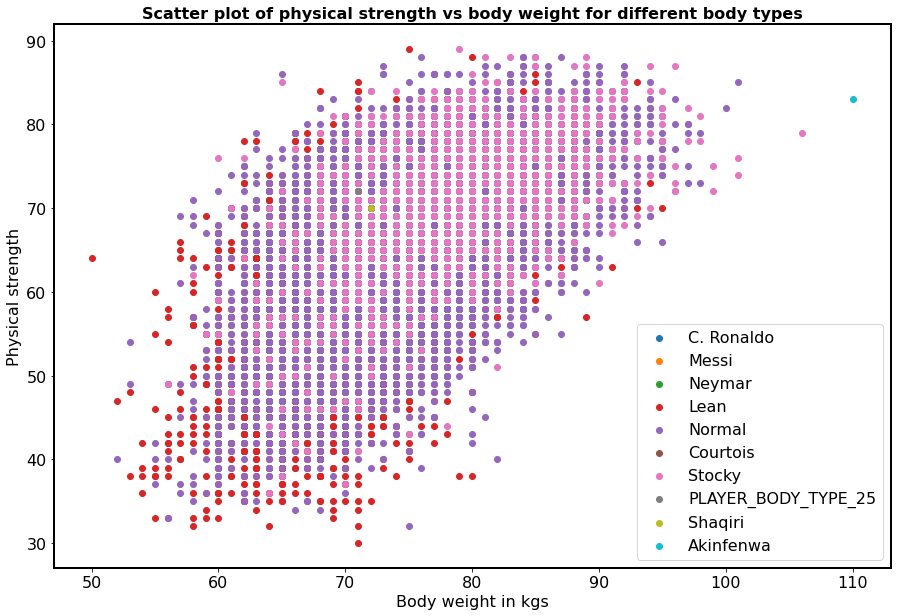

In [184]:
plt.figure(figsize=(15,10))
for btype in df['body_type'].unique():
    plt.scatter(df[df['body_type']==btype]['weight_kg'], df[df['body_type']==btype]['physic'], label=btype)

plt.xlabel("Body weight in kgs")
plt.ylabel("Physical strength")
plt.title("Scatter plot of physical strength vs body weight for different body types", fontweight='bold')
plt.legend(loc='lower right')
plt.show()

Except 'Akinfenwa', every other body type lies within the mass pool of all other players. 'Normal' seems to be the most dominating <i>body_type</i> across all body weights and physical strengths. Hence, we have assigned all the outlier body types to 'Normal'.

**The <i>Preprocessor</i> class:**

In order make preprocessing easier to read, code and reuse, we have put it in a class for this part. Preprocessing varies for different tasks, so this class is specifically used fot Part B. The functions used are explained below:
* <i>order_position()</i>: In the player_positions column, the ordering of positions of a player does not matter. For example, 'CDM, CM' and 'CM, CDM' are exactly the same. This function processes such differently ordered values and makes them uniform - that is, 'CM, CDM' and 'CDM, CM' both become 'CDM, CM'
* <i>eval_attribute()</i>: This is a helper function which evaluates the arthimetic operation in the string expression. For example, for a string input of '76+1', it return 77 as an integer.
* <i>get_final_potential()</i>: Several attributes of players are often given as the "current value + possible change over time". That is, if the 'pace' of a player is given as '80+3', it means that the current pace is 80 and the player can have a pace of 83 if certain conditions are met. As a part of preprocessing, we have only taken the final value of such players (in this case 83). This function takes all such columns and finds the final attribute value.
* <i>bdtype_normalize()</i>: Assigns the outlier body types as 'Normal'.
* <i>one_hot_encode()</i>: One-hot encodes all the categorical variables except the response variable.
* <i>fit()</i>: This is the driver code which calls all the other necessary function and returns the preprocessed data.

In [7]:
# A class that contains all the functions for preprocessing
class Preprocessor:
    def __init__(self, drop_list):
        self.drop_list = drop_list
    
    def eval_attribute(self, expr):
        """
        Return the final output after performing the arithmetic operation in string.

        Parameters
        ----------
        arg1: str
            A string containing the arithmetic expression to be evaluated

        Returns
        -------
        int
            The final value after the arithmetic operation
        """
        if type(expr)==int:
            return expr
        if expr.find("+")!=-1:
            return sum(map(int, expr.split("+")))
        elif expr.find("-")!=-1:
            return sum(map(int, expr.split("-")))
        else:
            return int(expr)
        
    def order_position(self, df):
        """
        Orders the player positions properly.

        Parameters
        ----------
        arg1 : Pandas DataFrame (or) Series
            A DataFrame or Series containing the player_positions columns values

        Returns
        -------
        Pandas DataFrame (or) Series
            The final column values after being corrected
        """
        for i in range(len(df)):
            df.iloc[i] = ', '.join(set(df.iloc[i].split(', ')))
        return df
        
    def get_final_potential(self, df):
        """
        Applies the eval_attribute function to every column that requires it.

        Parameters
        ----------
        arg1 : Pandas DataFrame
            The entire raw data in a Pandas DataFrame

        Returns
        -------
        Pandas DataFrame
            The final DataFrame with eval_attribute applied to all the columns that require it.
        """
        col_list = df.columns.tolist()
        toint_cols = col_list[col_list.index('attacking_crossing'):]
        
        for col in toint_cols:
            df[col].fillna(value = '0', inplace=True)
            df[col] = pd.Series(map(self.eval_attribute, df[col]))
            
        return df
    
    def bdtype_normalize(self, df):
        """
        Normalizes the body type outliers
        
        Parameters
        ----------
        arg1 : Pandas DataFrame
            The entire input DataFrame
            
        Returns
        -------
        Pandas DataFrame
            The modified DataFrame with normalized outliers
        """
        
        bdtype_outliers = df['body_type'].value_counts().index[df['body_type'].value_counts()==1].tolist()
        
        for bdtype in bdtype_outliers:
            ind = df.index[df['body_type']==bdtype][0]
            df['body_type'][ind] = 'Normal'
            
        return df
    
    def one_hot_encode(self, df):
        """
        One-hot encodes all the categorical variables except the response variable
        
        Parameters
        ----------
        arg1 : Pandas DataFrame
            The input DataFrame containing the categorical variables
            
        Returns
        -------
        Pandas DataFrame
            The processed DataFrame with one-hot encoded variables
        """
        
        obj_cols = [col for col in df.columns if df[col].dtype==object]
        obj_cols.remove('player_positions')
        
        return pd.get_dummies(df, columns = obj_cols)
    
    def fit(self, df):
        """
        Preprocesses the input raw data (the driver function). The only function that needs to be called outside the class.

        Parameters
        ----------
        arg1 : Pandas DataFrame
            The raw input data as a DataFrame

        Returns
        -------
        Pandas DataFrame
            The preprocessed output as a DataFrame
        """
        
        # Dropping the columns in drop_list
        df.drop(self.drop_list, axis=1, inplace=True)
        
        # Ordering player positions
        df['player_positions'] = self.order_position(df['player_positions'])
        
        # Getting the final value on player attributes
        df = self.get_final_potential(df)
        
        # Normalizing the body_type outliers
        df = self.bdtype_normalize(df)
        
        # Filling nans
        df.fillna(value = 0.0, inplace=True)
        
        # One-hot encoding
        df = self.one_hot_encode(df)
        
        return df

In [8]:
# Dropping features that should not be used
drop_list = ['sofifa_id', 'player_url', 'short_name', 'long_name', 'potential', 'wage_eur', 'real_face','nationality', \
             'player_traits', 'player_tags', 'dob', 'team_position', 'nation_position', 'loaned_from', 'joined', 'club']

# Initializing a Preprocessor object
preprocessor = Preprocessor(drop_list)

# Preprocessing the data
df_train = preprocessor.fit(df.copy())

# Having a quick look at the preprocessed data
df_train.head()

,age,height_cm,weight_kg,overall,value_eur,player_positions,international_reputation,weak_foot,skill_moves,release_clause_eur,...,work_rate_High/Medium,work_rate_Low/High,work_rate_Low/Low,work_rate_Low/Medium,work_rate_Medium/High,work_rate_Medium/Low,work_rate_Medium/Medium,body_type_Lean,body_type_Normal,body_type_Stocky
0,33,187,83,94,77000000,"ST, LW",5,4,5,127100000.0,...,0,0,0,0,0,0,0,0,1,0
1,31,170,72,94,110500000,"CF, ST, RW",5,4,4,226500000.0,...,0,0,0,0,0,0,1,0,1,0
2,26,175,68,92,118500000,"CAM, LW",5,5,5,228100000.0,...,1,0,0,0,0,0,0,0,1,0
3,27,193,76,91,72000000,GK,4,3,1,138600000.0,...,0,0,0,0,0,0,1,1,0,0
4,27,181,70,91,102000000,"CM, CAM",4,5,4,196400000.0,...,0,0,0,0,0,0,0,0,1,0


### Baseline Model and Feature Selection

We will fit a Logistic Regression model as a baseline model with all the features present right now. Based on feature importance, we can omit several features. Feature importance has been decided using hypothesis testing.

Performing feature selection on the baseline model is not the most efficient method. Features that seem insignifacnt to the baseline model might contribute significantly in a more sophisticated model. However, features like international reputation, duration of contract, etc. can be removed if they are not significant for baseline model.

In [9]:
# Number of bootstraps
numboot = 10

# List to store coefficients
coef_list = list()

for i in range(numboot):
    
    # Sampling the data
    df_sampled = df_train.sample(frac=1, replace=True)
    
    # Setting the predictor and response variables
    X_train = df_sampled.drop('player_positions', axis=1)
    y_train = df_sampled['player_positions']
    
    # Declaring a Logistic Regression model
    lreg = LogisticRegression()
    
    # Fitting the model in training data
    lreg.fit(X_train, y_train)
    
    # Appending the coefficients
    coef_list.extend(list(lreg.coef_))

We have taken 10 bootstraps and build a model on the sampled data. Each bootstrapped data presents a multi-class classification problem and hence, each bootstrap has ~350 models. So for 10 bootstraps, we get coefficients as though we were training ~3500 binary classifiers. On this, we perform hypothesis testing to determine significant features.

For each predictor $X_i$, the null and alternate hypothesis are:
<center> $H_0 :$ There is no relation between $X_i$ and $Y$
<center> $H_a :$ There is a relation between $X_i$ and $Y$
    
We use $\hat{t}-test$ as the test statistic. Over the bootstrapped data, it is given by:
<center> $\hat{t}-test = \frac{\mu_\hat{\beta_i}}{\sigma_\hat{\beta_i}}$
    
If the p-value for $|\hat{t}_i|$ is less than 0.05, we reject the null hypothesis.

In [10]:
#coef_list = [val.tolist() for val in coef_list]

# Computing the t-test values
tt = np.abs(np.divide(np.mean(coef_list, axis=0), np.std(coef_list, axis=0)))

# Getting the p-values
p_vals = stats.t.sf(tt, len(df_train)-1)*2

# Printing the significant features
print("The significant features are: ")
for i in range(len(p_vals)):
    if p_vals[i]<0.05:
        print(df.columns[i])

The significant features are: 


Hypothesis testing, unfortunately did not run successfully. We performed hyposthesis testing assuming that the Logistic Regression model does a good job in modelling the relations. The model could be the one to blame here as the coefficients are extremely small (of the order 1e-11), indicating that the model fails to relate attributes significantly to the response variable.

In [11]:
# Setting the predictor and response variables
X_train = df_train.drop('player_positions', axis=1)
y_train = df_train['player_positions']

# Creating the base model
base_model = LogisticRegression()

# Fitting the train data on the model
base_model.fit(X_train, y_train)

LogisticRegression()

### Decision Trees

We saw that Logistic Regression model performed poorly just by the fact that it did not have any significant features. We move on to more comlex models, starting with Decision Trees.

The stopping criteria we use is max_depth. In the next cell, we find the optimal value of max_depth using cross-validation approach.

In [13]:
# Setting the random state in a variable for easy modification
random_state = 44

# The maximum value of max-depth to try
depth_limit = 25

# List to store the accuracies
accuracy_list = list()

# Iterating over each max_depth value
for d in range(1,depth_limit+1):
    
    # Declaring a Decision Tree model with the desired max_depth
    dtree = DecisionTreeClassifier(max_depth=d, random_state=random_state)
    
    # Getting the scores via cross_validate
    score = cross_validate(dtree, X_train, y_train, cv=5, scoring='accuracy')
    
    # Storing the accuracy values
    accuracy_list.append(np.mean(score['test_score']))

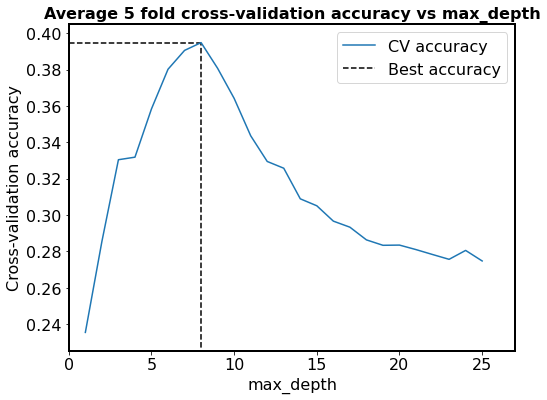

The best depth is:  8


In [14]:
# Finding best depth and accuracy
best_accuracy = max(accuracy_list)
best_depth = np.argmax(accuracy_list)+1

# Plotting accuracy vs depth
plt.figure(figsize=(8,6))
plt.plot(range(1,depth_limit+1), accuracy_list, label='CV accuracy')
plt.hlines(best_accuracy, xmin=0, xmax=best_depth, linestyles="dashed", colors='k', label="Best accuracy")
plt.vlines(best_depth, ymin = 0,ymax=best_accuracy, linestyles="dashed", colors='k')
plt.xlim((0, depth_limit+2))
plt.ylim((min(accuracy_list)-0.01, max(accuracy_list)+0.01))
plt.xlabel("max_depth")
plt.ylabel("Cross-validation accuracy")
plt.title("Average 5 fold cross-validation accuracy vs max_depth", fontweight="bold")
plt.legend()
plt.show()

print("The best depth is: ", best_depth)

Now that we have found the best depth, we will build a model with the best depth and store it for comparing the results later.

In [15]:
# Declaring the best Decision Tree model
dtree_model = DecisionTreeClassifier(max_depth = best_depth, random_state = random_state)

# Fitting the training data on the model
dtree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, random_state=44)

### Bagging

The advantage of bagging is that we can build deeper trees without overfitting the data. The number of trees, however needs to be fixed.

We begin by determining the optimal max_depth of the Decision Tree classifiers used in Bagging. After finding the best max_depth, we find the optimal number of estimator (or bootstraps) for bagging. This would complete the Bagging model.

For ensemble models, we have a quicker method to tune hypermeters by computing the OOB error. We have used OOB error to tune the hyperparameters over cross-validation.

In [65]:
# Setting the maximum max_depth limit
depth_limit = 35

# Creating a list to store the OOB errors
error_list = list()

for d in range(1, depth_limit+1):
    
    # Creating a Bagging Classifier model
    bag_classi = BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth=d), 
                                   random_state = random_state, 
                                   oob_score=True)
    
    # Fitting the training data
    bag_classi.fit(X_train, y_train)
    
    # Storing the OOB error
    error_list.append(1-bag_classi.oob_score_)

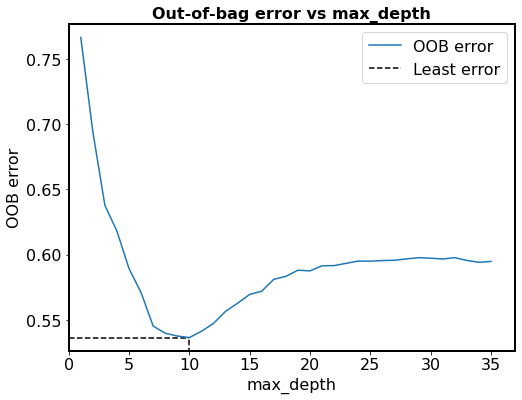

The best depth is:  10


In [66]:
# Finding best depth and error
best_error = min(error_list)
best_depth = np.argmin(error_list)+1

# Plotting OOB error vs depth
plt.figure(figsize=(8,6))
plt.plot(range(1,depth_limit+1), error_list, label='OOB error')
plt.hlines(best_error, xmin=0, xmax=best_depth, linestyles="dashed", colors='k', label="Least error")
plt.vlines(best_depth, ymin = 0,ymax=best_error, linestyles="dashed", colors='k')
plt.xlim((0, depth_limit+2))
plt.ylim((min(error_list)-0.01, max(error_list)+0.01))
plt.xlabel("max_depth")
plt.ylabel("OOB error")
plt.title("Out-of-bag error vs max_depth", fontweight="bold")
plt.legend()
plt.show()

print("The best depth is: ", best_depth)

Now we know what the best depth is, we move on to find the optimal number of estimators.

In [18]:
# Maximum limit for n_estimators
estimator_limit = 35

# List to store the OOB error
error_list = list()

for n in range(1,estimator_limit+1):
    
    # Creating a Bagging Classifier with the best depth and the current n_estimators
    bag_classi = BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth=best_depth),
                                   n_estimators = n, 
                                   random_state = random_state, 
                                   oob_score = True)
    
    # Fitting the training data
    bag_classi.fit(X_train, y_train)
    
    # Storing the OOB error
    error_list.append(1-bag_classi.oob_score_)

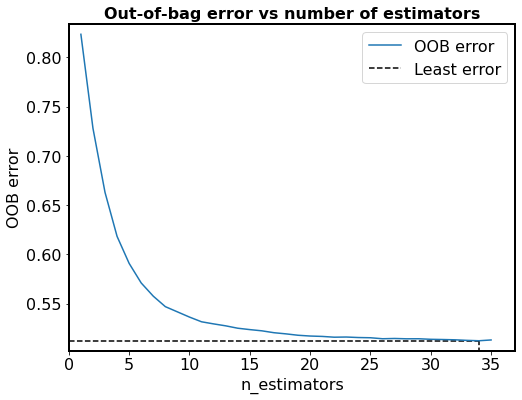

The best number of estimators is:  34


In [19]:
# Getting the optimal n_estimators
best_error = min(error_list)
best_n_estimators = np.argmin(error_list)+1

# Plotting OOB error vs n_estimators
plt.figure(figsize=(8,6))
plt.plot(range(1, estimator_limit+1), error_list, label="OOB error")
plt.hlines(best_error, xmin=0, xmax=best_n_estimators, linestyles="dashed", colors='k', label="Least error")
plt.vlines(best_n_estimators, ymin=0, ymax=best_error, linestyles="dashed", colors='k')
plt.xlim((0, estimator_limit+2))
plt.ylim((min(error_list)-0.01, max(error_list)+0.01))
plt.xlabel("n_estimators")
plt.ylabel("OOB error")
plt.title("Out-of-bag error vs number of estimators", fontweight="bold")
plt.legend()
plt.show()

print("The best number of estimators is: ", best_n_estimators)

We see that the error flatten after 20. So 100 is a safe value for n_estimators.

In [67]:
# Creating the optimal Bagging model
bagging_model = BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth=best_depth),
                                 n_estimators = 100,
                                 random_state = random_state)

# Fitting the data on the optimal Bagging model
bagging_model.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                  n_estimators=100, random_state=44)

### Random Forests

We know that trees in Bagging are highly correlated and Random Forests is a de-correlated version of Bagging. This should, in theory, offer better performance that Bagging.

Given that the best depth for single Decision Tree and Bagging are less than 10, it is safe to assume that Random Forest would have a similar best max_depth. This saves time in finding the best max_depth. The number of predictors to use at each split is given by $\sqrt{N_j}$, which in our case comes to be $\sqrt{99} \approx 10$. <i>sklearn</i> uses square-root of number of predictors by default to choose the number of predictors, hence this information need not be coded.

Let us begin by estimating the value of max_depth, by searching in a limited range based on our analysis from Bagging and Decision Tree classifier.

In [21]:
# Setting the maximum value for max_depth
depth_limit = 25

# A list to store the OOB errors
error_list = list()

for d in range(1, depth_limit+1):
    
    # Creating the Random Forest model
    ranf = RandomForestClassifier(max_depth = d, oob_score = True, random_state = random_state)
    
    # Fitting the data
    ranf.fit(X_train, y_train)
    
    # Storing the OOB error
    error_list.append(1 - ranf.oob_score_)

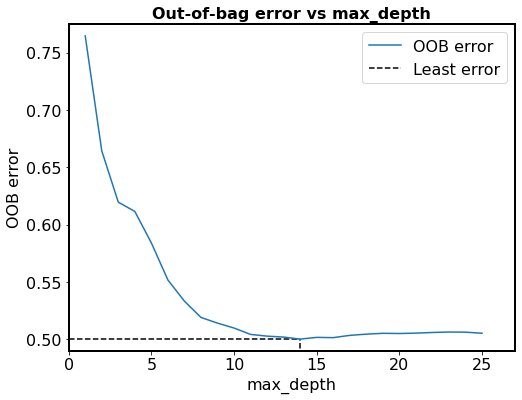

The best depth is:  14


In [22]:
# Finding the optimal max_depth
best_error = min(error_list)
best_depth = np.argmin(error_list)+1

# Plotting error vs depth
plt.figure(figsize=(8,6))
plt.plot(range(1,depth_limit+1), error_list, label='OOB error')
plt.hlines(best_error, xmin=0, xmax=best_depth, linestyles="dashed", colors='k', label="Least error")
plt.vlines(best_depth, ymin = 0,ymax=best_error, linestyles="dashed", colors='k')
plt.xlim((0, depth_limit+2))
plt.ylim((min(error_list)-0.01, max(error_list)+0.01))
plt.xlabel("max_depth")
plt.ylabel("OOB error")
plt.title("Out-of-bag error vs max_depth", fontweight="bold")
plt.legend()
plt.show()

print("The best depth is: ", best_depth)

The error flattens after 14 as max_depth value. We will choose 25 as the max_depth.

In [23]:
# The maximum limit on n_estimators
estimator_limit = 60

# A list to store the OOB errors
error_list = list()

for n in range(1, estimator_limit+1):
    
    # Creating the Random Forest model
    ranf = RandomForestClassifier(n_estimators = n, max_depth = best_depth, oob_score = True, random_state = random_state)
    
    # Fitting the training data
    ranf.fit(X_train, y_train)
    
    # Storing the OOB error values
    error_list.append(1 - ranf.oob_score_)

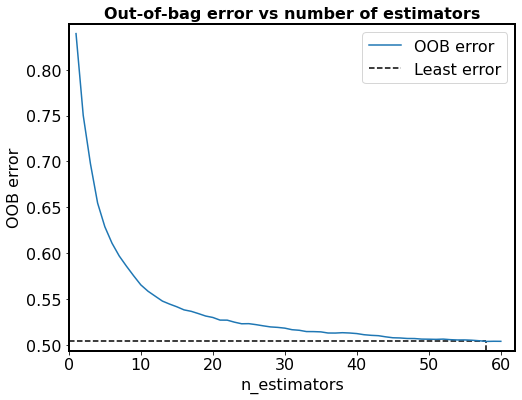

The best number of estimators is:  58


In [24]:
# Getting the optimal n_estimators
best_error = min(error_list)
best_n_estimators = np.argmin(error_list)+1

# Plotting OOB error vs n_estimators
plt.figure(figsize=(8,6))
plt.plot(range(1, estimator_limit+1), error_list, label="OOB error")
plt.hlines(best_error, xmin=0, xmax=best_n_estimators, linestyles="dashed", colors='k', label="Least error")
plt.vlines(best_n_estimators, ymin=0, ymax=best_error, linestyles="dashed", colors='k')
plt.xlim((0, estimator_limit+2))
plt.ylim((min(error_list)-0.01, max(error_list)+0.01))
plt.xlabel("n_estimators")
plt.ylabel("OOB error")
plt.title("Out-of-bag error vs number of estimators", fontweight="bold")
plt.legend()
plt.show()

print("The best number of estimators is: ", best_n_estimators)

We see that the error keeps decreasing and is almost flattening at n_estimators = 60. The default value used by RandomForestClassifier is 100, which seems like a good value for this task. Hence, we have decided to stick to the default value.

In [42]:
# Creating the best Random Forest model
random_forest_model = RandomForestClassifier(max_depth = 25, oob_score = True, random_state = True)

# Fitting the training data
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=25, oob_score=True, random_state=True)

### Boosting

One method to improve performance is by smoothing the variance of deep Decision Trees. Another method is to reduce the bias by putting together several weak models. This is done by Boosting.

According to the documentation, there are two hyperparameters - <i>n_estimators</i> and <i>learing_rate</i>. There is a trade_off between these two, so tuing one of them would be enough. We have tuned <i>n_estimators</i>. 

In [26]:
# Setting the maximum limit for n_estimators
estimator_limit = 35

# Creating a list to store the CV accuracy
accuracy_list = list()

for n in range(1,estimator_limit+1):
    
    # Creating a AdaBoost model
    ada_boost = AdaBoostClassifier(n_estimators = n, random_state = random_state)
    
    # Getting the 5-fold cross-validation score
    score = cross_validate(ada_boost, X_train, y_train, cv=5, scoring="accuracy")
    
    # Storing the scores
    accuracy_list.append(np.mean(score['test_score']))

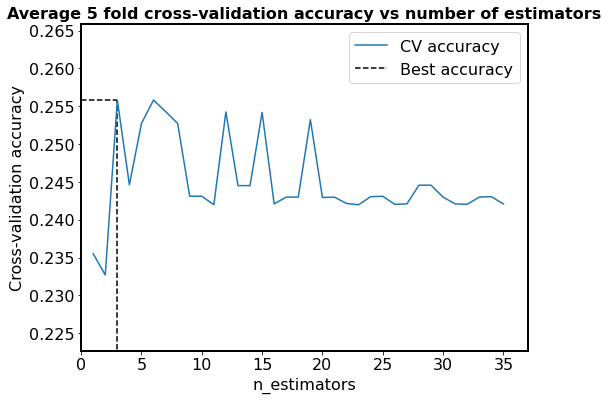

In [27]:
# Finding the optimal n_estimators
best_accuracy = max(accuracy_list)
best_n_estimators = np.argmax(accuracy_list)+1

# Plotting accuracy vs n_estimators
plt.figure(figsize=(8,6))
plt.plot(range(1,estimator_limit+1), accuracy_list, label="CV accuracy")
plt.hlines(best_accuracy, xmin=0, xmax=best_n_estimators, linestyles="dashed", colors="k", label="Best accuracy")
plt.vlines(best_n_estimators, ymin=0, ymax=best_accuracy, linestyles="dashed", colors="k")
plt.xlim((0, estimator_limit+2))
plt.ylim((min(accuracy_list)-0.01, max(accuracy_list)+0.01))
plt.xlabel("n_estimators")
plt.ylabel("Cross-validation accuracy")
plt.title("Average 5 fold cross-validation accuracy vs number of estimators", fontweight="bold")
plt.legend()
plt.show()

The accuracy keeps fluctuating between 0.23 - 0.26 and later flattens out. The default value of n_estimators in sklearn is 100 and we will keep it that way as we haven't found any other better value.

In [48]:
# Building the best AdaBoost model
boosting_model = AdaBoostClassifier(random_state = random_state)

# Fitting the training data
boosting_model.fit(X_train, y_train)

AdaBoostClassifier(random_state=44)

## Comparing performance of all the models

We built a Logistic Regression model as a baseline model, followed by a single Decision Tree, Bagging, Random Forest and Boosting. In theory, the performance should consistently increase as the model gets more sophisticated. We will check that soon.

In order to test our model, we have been asked to use the FIFA 20 dataset, but using only players belonging to the following clubs:
* FC Barcelona
* FC Bayern München
* Real Madrid
* Paris Saint-Germain
* Juventus
* Atlético Madrid
* Manchester City
* Liverpool
* Manchester United

The first step is to load the test data, select the players belonging to these specific clubs and then preprocess it the same way training data was preprocessed.

In [29]:
# Loading the test data (FIFA 20 dataset)
df_test = pd.read_csv('./data/players_20.csv')

# The list of clubs to test
club_list = ["Real Madrid", "FC Bayern München", "FC Barcelona", "Juventus", "Manchester United", \
             "Manchester City", "Liverpool", "Atlético Madrid", "Paris Saint-Germain"]

# Indices of players to retain after preprocessing
retain_indices = df_test.index[df_test['club'].isin(club_list)].tolist()

# Preprocessing the data same way as the training data
df_test = preprocessor.fit(df_test.copy())

# Retaining players from the club_list
df_test = df_test.iloc[retain_indices].reset_index(drop=True)

Retaining the players and then preprocessing the test data is computationally efficient. However, when we tried that, we found that none of the players from the clubs mentioned have a work_rate value of 'Low/Low'. This leads to a missing column if we retain players first and then process the data. 

In [30]:
# Taking a quick look at the test data
df_test.head()

,age,height_cm,weight_kg,overall,value_eur,player_positions,international_reputation,weak_foot,skill_moves,release_clause_eur,...,work_rate_High/Medium,work_rate_Low/High,work_rate_Low/Low,work_rate_Low/Medium,work_rate_Medium/High,work_rate_Medium/Low,work_rate_Medium/Medium,body_type_Lean,body_type_Normal,body_type_Stocky
0,32,170,72,94,95500000,"CF, ST, RW",5,4,4,195800000.0,...,0,0,0,0,0,1,0,0,1,0
1,34,187,83,93,58500000,"ST, LW",5,4,5,96500000.0,...,0,0,0,0,0,0,0,0,1,0
2,27,175,68,92,105500000,"CAM, LW",5,5,5,195200000.0,...,1,0,0,0,0,0,0,0,1,0
3,26,188,87,91,77500000,GK,3,3,1,164700000.0,...,0,0,0,0,0,0,1,0,1,0
4,28,175,74,91,90000000,"CF, LW",4,4,4,184500000.0,...,1,0,0,0,0,0,0,0,1,0


It is mentioned in the problem statement that the scoring metric is classification accuracy. So we find the classification accuracy of all the models built so far. 

It is easier to have a dictionary with model names and the actual models in it. This saves programming time and effort.

In [68]:
# Creating the model dictionary
model_dict = {
    "Baseline model": base_model,
    "Decision Tree": dtree_model,
    "Bagging": bagging_model,
    "Random Forest": random_forest_model,
    "Boosting": boosting_model
}

In [51]:
# Setting the predictor and true response values
X_test = df_test.drop('player_positions', axis=1)
y_test = df_test['player_positions']

### Classification accuracy

In [69]:
# Computing classification accuracy for all the models
t1 = PrettyTable(['Model name', 'Classification accuracy'])

for model_name, model in model_dict.items():
    score = model.score(X_test, y_test)
    t1.add_row([model_name, score])
    
print(t1)

+----------------+-------------------------+
|   Model name   | Classification accuracy |
+----------------+-------------------------+
| Baseline model |   0.12195121951219512   |
| Decision Tree  |   0.42160278745644597   |
|    Bagging     |    0.4912891986062718   |
| Random Forest  |    0.662020905923345    |
|    Boosting    |   0.13588850174216027   |
+----------------+-------------------------+


**Random Forest** is the best model for this task according to classification accuracy.

### F1 score

In [70]:
# Computing the f1-score for all the models
t2 = PrettyTable(['Model name', 'F1 score'])

for model_name, model in model_dict.items():
    score = f1_score(y_test, model.predict(X_test), average="weighted")
    t2.add_row([model_name, score])
    
print(t2)

+----------------+---------------------+
|   Model name   |       F1 score      |
+----------------+---------------------+
| Baseline model | 0.03799040264919315 |
| Decision Tree  |  0.3479467741683974 |
|    Bagging     |  0.4092438249493772 |
| Random Forest  |  0.6363220193369281 |
|    Boosting    | 0.03592984113860509 |
+----------------+---------------------+


Again, based on F1 score, Random Forest performs best.

In [71]:
# Setting the best model
best_model = random_forest_model

### The predictions

In [72]:
# Getting the predictions from the best model
y_pred = best_model.predict(X_test)

In order to visualize the predictions, it is convenient to categorize the positions into attackers, midfielders, defenders and goalkeepers.

In [108]:
# Defining and grouping positions
attack_positions = {'ST', 'LW', 'RW', 'CF', 'LF', 'RF'}
midfield_positions = {'LM', 'RM', 'CM', 'CAM', 'CDM'}
defence_positions = {'LWB', 'RWB', 'CB', 'LB', 'RB'}
goalkeeper = {'GK'}

In [116]:
def set_positions(y):
    """
    Categorizes the positions in y into attackers, midfielders, defenders and goalkeepers
    
    Parameters
    ----------
    arg1 : list (or) Pandas Series (or) Numpy 1D array
    
    Returns
    -------
    Dictionary
        Dictionary containing the count of number of attacker, midfielders, defenders and goalkeepers
    """
    
    position_dict = {
        "Attackers": 0,
        "Midfielders": 0,
        "Defenders": 0,
        "Goalkeepers": 0
    }
    
    for i in range(len(y)):
        # Splitting the string into individual positions
        y_split = set(y[i].split(", "))
        
        # Checking if any position in y[i] is an attacking position
        if bool(y_split & attack_positions):
            position_dict["Attackers"]+=1
            
        # Checking if any position in y[i] is a midfield position
        if bool(y_split & midfield_positions):
            position_dict["Midfielders"]+=1
            
        # Checking if any position in y[i] is a defensive position
        if bool(y_split & defence_positions):
            position_dict["Defenders"]+=1
            
        # Checking if any position in y[i] is a goalkeeper
        if bool(y_split & goalkeeper):
            position_dict["Goalkeepers"]+=1
            
    return position_dict

In [118]:
# Categorizing the original and predicted positions
predicted_positions = set_positions(y_pred)
original_positions = set_positions(y_test)

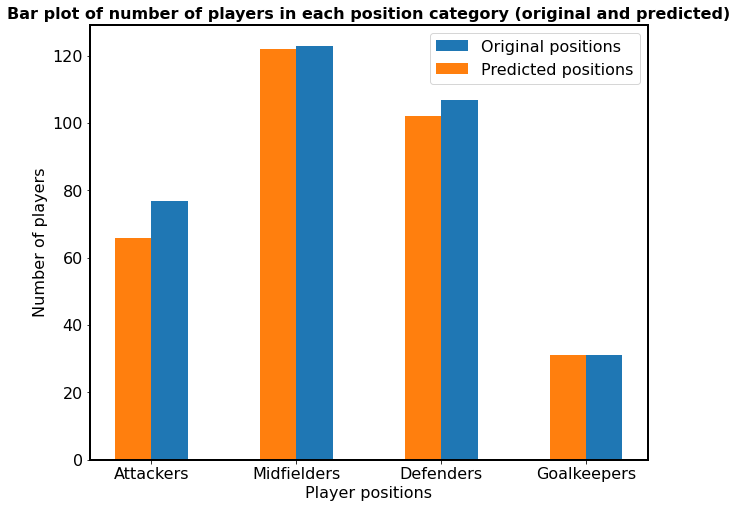

In [177]:
plt.figure(figsize=(10,8))
w = 0.25
plt.bar(original_positions.keys(), original_positions.values(), +w, align="edge", label = "Original positions")
plt.bar(predicted_positions.keys(), predicted_positions.values(), -w, align="edge", label = "Predicted positions")
plt.xlabel("Player positions")
plt.ylabel("Number of players")
plt.title("Bar plot of number of players in each position category (original and predicted)", fontweight="bold")
plt.legend()
plt.show()

The plot above gives a visual representation of number of players in each category, both in original and predicted values. They are very similar and the differences are negligible. There is almost no difference in the number of goalkeepers.

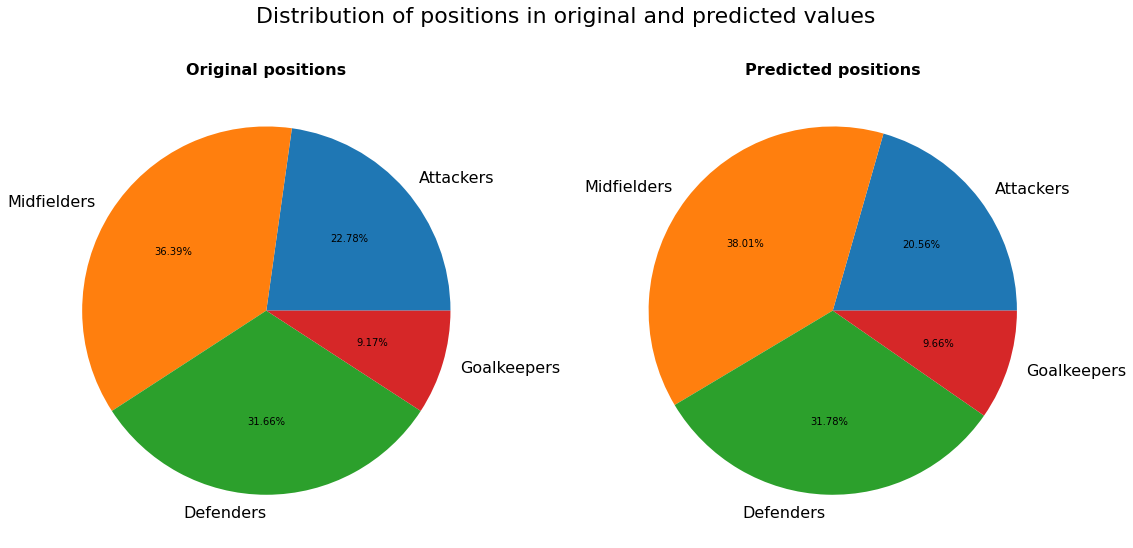

In [176]:
fig, axs = plt.subplots(1,2)
axs[0].pie(original_positions.values(), labels = original_positions.keys(), autopct='%1.2f%%')
axs[0].set_title("Original positions", fontweight = "bold")

axs[1].pie(predicted_positions.values(), labels = predicted_positions.keys(), autopct='%1.2f%%')
axs[1].set_title("Predicted positions", fontweight = "bold")

fig.suptitle("Distribution of positions in original and predicted values")
plt.tight_layout()
plt.subplots_adjust(top=1.1)
plt.show()

From the plot above, the distribution of player positions are identical in both plots excepth that the model predicted more players as midfielders and less players as attackers. 

It would be interesting to see if the model captures any relationship or ordering between position categories. The following code cell aids in finding that.

In [226]:
# A function to categorize the position as attacker, midfielder, defender or goalkeeper
def categorize(y):
    """
    Categorized player positions as 3, 2, 1 and 0 based on how high up the field they play
    
    Parameters
    ----------
    arg1 : list
        A list containing the abbreviated player position strings
        
    Returns
    -------
    int
        The encoded value of the position
    """
    y_split = set(y.split(", "))
    
    if bool(y_split & attack_positions):
        return 3
    
    if bool(y_split & midfield_positions):
        return 2
    
    if bool(y_split & defence_positions):
        return 1
    
    if bool(y_split & goalkeeper):
        return 0

# A list to store the category of mis-classified examples
y_test_cat = []
y_pred_cat = []

for i in range(len(y_test)):
    # If i-th example is misclassified, store its category
    if y_pred[i] != y_test[i]:
        y_test_cat.append(categorize(y_test[i]))
        y_pred_cat.append(categorize(y_pred[i]))

The above cell encodes attackers as 3, midfielders as 2, defenders as 1 and goalkeepers as 0. The difference between the predicted and actual value should be ideally 0 (indicating that the model predicted the same position). The higher the magnitude of difference, the worse the model has performed. That is, if the model predicted a goalkeeper as an attacker, the magnitude of this "classification difference" would be 3.

In [225]:
print("The maximum classification difference is: ", max(np.abs(np.array(y_test_cat)-np.array(y_pred_cat))))

The maximum classification difference is:  1


This classification difference highlights an important property of the model - it captured the relative position of the players. The model never classified a defender as an attacker and an attacker as a goalkeeper. It modelled the fact that midfielders and attackers are more closely related than defenders and attackers. This fact is borne by the the maximum classification difference printed above.

## Discussions and conclusion

The task of predicting the player position was modelled using multiple techniques learnt in class. Based on the models built, it seems like Random Forest performs best. But there are several factors to consider regarding the performance of these models:
* <u>Scoring method</u>: Classification accuracy could make it look like the models are performing poorer than they actually are. For example, a player position of 'LW, ST' denotes that the player is an attacker. A model that predicts only 'ST' or 'ST, CF' gets penalized the same as a model that predicts 'GK'. In reality, the model which predicted only 'ST' or 'ST, CF' is performing better than the model predicting 'GK'.


* <u>Position relation</u>: The fact that the maximum classification difference is 1 indicates that the model actually performs very well. Classification accuracy is unforgiving, as explained in the previous point. The fact that no defender got classified as an attacker or vice-versa indicates that the model understands the relation between player positions (that is, midfielders are more related to attackers than goalkeepers in terms of skills and functionality). To realize how good the model actually is, we need to have a better method for representing the response variables, as mentioned in the points below. 


* <u>Data preprocessing</u>: While preprocessing, we had to one-hot encode several features, which can affect the performance of the model by creating sparse matrices. Moreover, exclusion of several features and inclusion of several others cannot be completely justified. 


* <u>Response variable</u>: The response variable had multiple positions for several players. As far as the model goes, it treats 'ST' the same as 'GK' and 'ST, LW', while in reality 'ST, LW' is more closely related to 'ST' than 'GK'. One-hot encoding the response variable and assigning multiple positions to players introduces several new problems in classification thresholds. A better representation of data is required in this case.


* <u>Categorizing positions</u>: Categorizing player positions as "attack", "midfield", "defence" and "goalkeeper" can significantly improve the model performance but this waters down the problem complexity. We have avoided such categorization and even when taking multiple positions, Random Forest gives a accuracy of ~65%.


* <u>Class imbalance</u>: With the given processing for response variables, there is a major class imbalance. Training ensemble models with balanced class_weights only deteriorates the performance of the model.


* <u>Hyperparameters</u>: We tuned the hyperparameters based on OOB error for ensemble methods as it is computationally cheaper and easier. Small changes in hyperparameters can alter the performance of the model, sometimes making it better. 


* <u>Hypothesis Testing</u>: Our attempt at hypothesis testing to find significant features using baseline model failed. By looking at the magnitude of coefficients of the baseline model we realized that the model performed very poorly. This statement is justified by the final performance of the model by looking at the classification accuracy and F1 score. Both indicate that the baseline model performs very poorly and this model is not suitable for hypothesis testing.


* <u>Model Performance</u>: As expected, the performance steadily increased till Random Forest but plummeted at boosting. It is understandable given that boosting works on reducing the bias whereas Random Forest works on reducing the variance. Given the magnitude of the problem, deep Decision Trees definitely perform better and reducing the variance could be a better approach than to build better model using many shallow trees.